In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from math import *

In [2]:
class Head(nn.Module):
  """one head of self-attention"""

  def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(n_embd, head_size, bias=False)
      self.query = nn.Linear(n_embd, head_size, bias=False)
      self.value = nn.Linear(n_embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)
    # compute attention score ("affinities")
    wei = q @ k.transpose(-2, -1) * C**-0.5
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    wei = F.softmax(wei, dim=-1)# (B, T, T)
    wei = self.dropout(wei)
    # perform the weighted aggregation of the values
    v = self.value(x)
    out = wei @ v # (B, T, C)
    return out




class MultiHeadAttention(nn.Module):
  """multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(num_heads * head_size, n_embd)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out




class FeedForward(nn.Module):
  """a simple linear layer followed by a non-linearity"""

  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)




class Block(nn.Module):
  """ Transformer block: communication followed by computation"""

  def __init__(self, n_embd, n_head):
     super().__init__()
     head_size = n_embd // n_head
     self.sa = MultiHeadAttention(n_head, head_size)
     self.ffwd = FeedForward(n_embd)
     self.ln1 = nn.LayerNorm(n_embd)
     self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class Transformer(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, device):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.block_size = block_size
        self.n_head = n_head
        self.n_layer = n_layer
        self.device = device

        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(self.vocab_size, self.n_embd)
        self.position_embedding_table = nn.Embedding(self.block_size, self.n_embd)
        self.blocks = nn.Sequential(*[Block(self.n_embd, n_head=self.n_head) for _ in range(self.n_layer)])
        self.ln_f = nn.LayerNorm(self.n_embd)
        self.lm_head = nn.Linear(self.n_embd, self.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device)) # T, C

        x = tok_emb + pos_emb # (B, T, C)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) # (B, T, self.vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last self.block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx, idx_next



@torch.no_grad()
def estimate_loss(model, eval_iters, block_size, batch_size):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, block_size, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out



In [27]:
try :
  with open('/content/drive/MyDrive/Colab Notebooks/datasets/input.txt', 'r', encoding='utf-8') as f:
      text = f.read()
except:
  !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
  with open('input.txt', 'r', encoding='utf-8') as f:
      text = f.read()
print(len(text))

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.1*len(data)) # first 90% will be train, rest val
train_data = data[n:]
val_data = data[:n]

"""
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
"""

# data loading
def get_batch(split, block_size, batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

--2024-01-30 15:16:41--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-01-30 15:16:42 (19.1 MB/s) - ‘input.txt.1’ saved [1115394/1115394]

1115394


In [5]:
# hyperparameters
batch_size = 24 # how many independent sequences will we process in parallel?
block_size = 300 # what is the maximum context length for predictions? # impact little
eval_iters = 3 # more fast ( when it's low )
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 292  # impact big 8*12
n_head = 6    # no impact
n_layer = 6   # impact
dropout = 0.2 # no impact
# ------------

model = Transformer(vocab_size, n_embd, block_size, n_head, n_layer, device)
m = model.to(device)
#torch.save(m.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models/hound7,1M')

paras = list(str(sum(p.numel() for p in m.parameters())))
num = len(paras)-1
for i in paras:
  if num % 3 == 0:
    print(i, end=" ")
    pass
  else:
    print(i, end="")
    pass
  num -= 1


6 254 705 

  0%|          | 1/500 [00:00<05:00,  1.66it/s]

step 0: train loss 1.7716, val loss 1.8359


 20%|██        | 101/500 [00:18<02:21,  2.82it/s]

step 100: train loss 1.7588, val loss 1.8288


 40%|████      | 201/500 [00:37<01:37,  3.06it/s]

step 200: train loss 1.7508, val loss 1.8500


 60%|██████    | 301/500 [00:56<01:04,  3.10it/s]

step 300: train loss 1.8110, val loss 1.8396


 80%|████████  | 401/500 [01:15<00:30,  3.23it/s]

step 400: train loss 1.7503, val loss 1.8209


100%|██████████| 500/500 [01:32<00:00,  5.40it/s]


tensor(1.8195, device='cuda:0', grad_fn=<NllLossBackward0>)


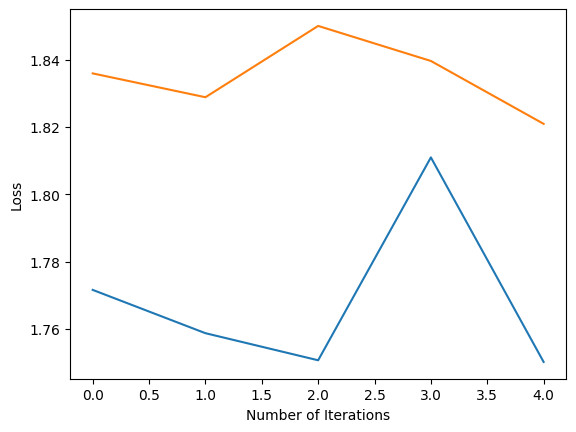

In [31]:
model = Transformer(vocab_size, n_embd, block_size, n_head, n_layer, device)
model.load_state_dict(torch.load('/content/modelchars1'))
m = model.to(device)

# create a PyTorch optimizer
learning_rate = 5e-5
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

loss_list_t = []
loss_list_v = []
max_iters = 500
eval_interval = 100

for iter in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets

    if iter % eval_interval == 0:
        torch.save(m.state_dict(), '/content/modelchars1')

        losses = estimate_loss(m, eval_iters, block_size, batch_size)
        loss_list_t.append(losses['train'])
        loss_list_v.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")


    # sample a batch of data
    xb, yb = get_batch('train', block_size, batch_size)

    # evaluate the loss
    logits, loss = model(xb, yb)
    #if iter % eval_interval == 0:
     # loss_list.append(loss.item())

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# draw loss
print(loss)
plt.plot(range(len(loss_list_t)), loss_list_t)
plt.plot(range(len(loss_list_v)), loss_list_v)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()
# generate from the model
#context = torch.zeros((1, 1), dtype=torch.long, device=device)
#print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))

In [ ]:
# draw loss
print(loss)
plt.plot(range(len(loss_list_t)), loss_list_t)
plt.plot(range(len(loss_list_v)), loss_list_v)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [29]:
model = Transformer(vocab_size, n_embd, block_size, n_head, n_layer, device)
model.load_state_dict(torch.load('/content/modelchars1'))
model = model.to(device)

context = torch.zeros((1, 1), dtype=torch.long, device=device)
#print(decode(   m.generate(context, max_new_tokens=100)[0].tolist()[0]   ))


for _ in range(500):
  context, out = model.generate(context, max_new_tokens=1)
  print(decode(out[0].tolist()), end="")


no mer; thask wilt gle, ox and ca,
Fir pet tis will my to ake and whathee this ccry mach.
To tat looked, tin curponnus dupet warthe is.

JUllafiefft me sirs as ellabll; as hame be:
Laze; ty I corsune; he wand the he clon, Faterd bighth
Thy, Thare me deant alls, fig eapp mes quet wor dotl.

OMERIVEN:
Yor Edquead nike.

IShe wich willt! wit, inh iming igs.

FRUMERCHCEM:
Thop my donotnd allled and thiee rap't;
He hiss leary nith bach speet;'dlile bnot ol
Forr frach Gound. Wet:
That seait bese!ll, s